<a href="https://colab.research.google.com/github/tuinlamp/Thesis/blob/master/NDVI_Time_Series_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#importing Earth Engine package
import ee

In [0]:
#then we need to authenticate
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=lYE3vSzv2V-q8rVCYjx-cGdZhhS_BDl1Jvy2oP3UO5o&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/ygEZr7MMrjwjAycg6wp4ZToz_9rdagc7Hn5yvrKNsFI4TiceC4V5sxw

Successfully saved authorization token.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Importing all relevant libraries here

import datetime as dt
import pandas as pd
import numpy as np
from dbfread import DBF
import random

In [0]:
!pip install dbfread


In [0]:
#Create collection from Landsat 7 images (2000-2003 & 2007-2008)

def create_collection(coord_x, coord_y, start_date, end_date):
  location_test = ee.Geometry.Point(coord_x, coord_y)

  l7_collection = (ee.ImageCollection("LANDSAT/LE07/C01/T1_SR").select(['B1','B2','B3',
                                                                        'B4','B5','B6','B7', 'sr_atmos_opacity', 'sr_cloud_qa', 'pixel_qa', 'radsat_qa']) #selects the S2 Surface reflectance product in GEE #selects the bands of interest
                  .filter(ee.Filter.date(start_date, end_date)) #filtes on the time
                  .filterBounds(location_test)) #filters on the Aoi

  count = l7_collection.size()
  print('Nr of images in collection: ', str(count.getInfo())+'\n')
  return l7_collection            

In [0]:
#Prepare entries from the image collection for the dataframe

def createEntry2(input_string, img, location_test):
  date_pre = input_string[-8:]
  date_pre
  date_pre = dt.datetime.strptime(date_pre, "%Y%m%d")
  date = date_pre.date()
  projection = img.projection().getInfo()['crs']
  B1 = img.select('B1').reduceRegion(ee.Reducer.first(),location_test,1,crs=projection).get('B1').getInfo()
  B2 = img.select('B2').reduceRegion(ee.Reducer.first(),location_test,1,crs=projection).get('B2').getInfo()
  B3 = img.select('B3').reduceRegion(ee.Reducer.first(),location_test,1,crs=projection).get('B3').getInfo()
  B4 = img.select('B4').reduceRegion(ee.Reducer.first(),location_test,1,crs=projection).get('B4').getInfo()
  B5 = img.select('B5').reduceRegion(ee.Reducer.first(),location_test,1,crs=projection).get('B5').getInfo()
  B6 = img.select('B6').reduceRegion(ee.Reducer.first(),location_test,1,crs=projection).get('B6').getInfo()
  #B7 = img.select('B7').reduceRegion(ee.Reducer.first(),location_test,1,crs=projection).get('B7').getInfo()
  #Atmos_Opacity = img.select('sr_atmos_opacity').reduceRegion(ee.Reducer.first(),location_test,1,crs=projection).get('sr_atmos_opacity').getInfo()
  Cloud_Quality = img.select('sr_cloud_qa').reduceRegion(ee.Reducer.first(),location_test,1,crs=projection).get('sr_cloud_qa').getInfo()
  #Pixel_Quality = img.select('pixel_qa').reduceRegion(ee.Reducer.first(),location_test,1,crs=projection).get('pixel_qa').getInfo()
  #Radsat_Quality = img.select('radsat_qa').reduceRegion(ee.Reducer.first(),location_test,1,crs=projection).get('radsat_qa').getInfo()
  entry = np.array([date, B1, B2, B3, B4, B5, B6,Cloud_Quality])
  return entry

In [0]:
#Loop over the image collection and collect all band info + date of satellite image

def create_information(sat_collection):
  df = pd.DataFrame(columns = ['Date', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6','sr_cloud_qa'])

  count = sat_collection.size()

  for i in range(count.getInfo()):
    mid_step = sat_collection.toList(count)
    sat_img = ee.Image(mid_step.get(i))
    sat_img_meta = sat_img.getInfo() 
    #print('Image',i,'/',count.getInfo(),' is being processed. Image name:',sat_img_meta.get('properties',{}).get('system:index'))
    band_name = 'sr_cloud_qa'
    input_string = sat_img_meta.get('properties',{}).get('system:index')
    entry = createEntry2(input_string, sat_img, location_test)
    df.loc[i] = entry

  return df  

In [0]:
#A loop that creates a dataframe collecting the NDVI values of each date

def ndvi(x):
    try:
        return (x['B4'] - x['B3']) / (x['B4'] + x['B3'])
    except:
        pass


def create_NDVI(df):
  df_NDVI = pd.DataFrame(columns = ['Date', 'NDVI'])
  i = 0

  for index, row in df.iterrows():
    if row['sr_cloud_qa'] == 0: #sr_cloud_qua value of 0 means no clouds
      i += 1
      date = row['Date']
      ndvi_val = ndvi(row)
      entry = np.array([date, ndvi_val])
      df_NDVI.loc[i] = entry

  return df_NDVI

In [0]:
#Retreive NDVI time series from a single point

def NDVI_timeseries(coord_x, coord_y, start_date, end_date):
  sat_collection = create_collection(coord_x, coord_y, start_date, end_date)
  df = create_information(sat_collection)
  df_NDVI = create_NDVI(df)
  return df_NDVI

In [0]:
def iterate_sample_NDVI(sample, start_date, end_date):
  NDVI_entries = [ ]
  i = 0

  for x in sample:
    x_coord = x[0]
    y_coord = x[1]
    print("Progress: point ", i, " out of ", len(sample))
    NDVI_entry = NDVI_timeseries(x_coord, y_coord, start_date, end_date)
    NDVI_entries.append(NDVI_entry)
    i += 1

  column_names = ["Datum", "NDVI"]
  df_total = pd.DataFrame(columns = column_names)
  df_total = pd.concat(NDVI_entries, ignore_index=True)  
  df_total['NDVI'] = df_total['NDVI'].astype(float)
  df_total['Date'] =  pd.to_datetime(df_total['Date'])
  df_total_mean = df_total.set_index('Date').groupby(pd.Grouper(freq='D')).mean()
  return df_total_mean.dropna()

In [0]:
def create_NDVI_timeseries(filename, start_date, end_date, n_samples):
  coordinaten_plot = [ ]

  for record in DBF(filename):
    entry = (record[('X')],record[('Y')])
    coordinaten_plot.append(entry)

  sample = random.sample(coordinaten_plot, n_samples)
  df_NDVI = iterate_sample_NDVI(sample, start_date, end_date)
  return df_NDVI  

In [0]:
start_date = '2013-01-01'
end_date = '2017-01-01'
filename = 'Export_E20.dbf'
n_samples = 10

df_NDVI = create_NDVI_timeseries(filename, start_date, end_date, n_samples)

Progress: point  0  out of  10
Nr of images in collection:  128

Progress: point  1  out of  10
Nr of images in collection:  126

Progress: point  2  out of  10
Nr of images in collection:  128

Progress: point  3  out of  10
Nr of images in collection:  127

Progress: point  4  out of  10
Nr of images in collection:  128

Progress: point  5  out of  10
Nr of images in collection:  126

Progress: point  6  out of  10
Nr of images in collection:  130

Progress: point  7  out of  10
Nr of images in collection:  130

Progress: point  8  out of  10
Nr of images in collection:  127

Progress: point  9  out of  10
Nr of images in collection:  127



In [0]:
coord_x = 5.370142
coord_y = 52.445394
start_date = '2013-01-01'
end_date = '2014-01-01'

#df_NDVI = NDVI_timeseries(coord_x, coord_y, start_date, end_date)

In [0]:
df_NDVI.to_csv("NDVI_10_SAMPLES_E20_2013_2017")

#Visualizations


In [0]:
#df_NDVI = df_NDVI.astype(float)
#df_NDVI
#df_NDVI.plot(linestyle='--', marker='o', color='b')

import plotly.express as px
import plotly.graph_objects as go

#df_NDVI = df_NDVI.sort_values('Date')
fig = go.Figure([go.Scatter(x=df_NDVI.index, y=df_NDVI['NDVI'])])
fig.show()

#This figure shows missing data spots

In [0]:
df_NDVI['Date'] = pd.to_datetime(df_NDVI['Date'])
df_NDVI['NDVI'] = df_NDVI['NDVI'].astype(float)

#Create temporary dataframe with empty values on every day (1999-01-01 to 2013-01-01)
df_temp = pd.DataFrame({'Date': pd.date_range(start='1999-01-01', end='2013-01-01', freq='d'), 'NDVI': np.nan})
df_temp['Date'] = pd.to_datetime(df_temp['Date'])

In [0]:
#Combine temp and NDVI data

df_NDVI_all_days = pd.merge(df_temp, df_NDVI, how='outer', on='Date')
df_NDVI_all_days = df_NDVI_all_days.drop(columns=['NDVI_x'])
df_NDVI_all_days = df_NDVI_all_days.rename(columns={'NDVI_y' : 'NDVI'})
df_NDVI_all_days['NDVI'].interpolate(method='linear', inplace=True)


In [0]:
df_NDVI_all_days.to_csv(r'NDVIvalues_pixel.csv')

# Graphs for the NDVI on chosen pixel

In [0]:
fig2 = go.Figure([go.Scatter(x=df_NDVI_all_days['Date'], y=df_NDVI_all_days['NDVI'])])

#Compares graph with missing data and new one with linear imputation
fig.show()
fig2.show()

In [0]:
df_NDVI_all_days2 = df_NDVI_all_days

In [0]:
df_NDVI_all_days

,Date,NDVI,Month,year,day
0,1999-01-01,NaN,NaN,1999,001
1,1999-01-02,NaN,NaN,1999,002
2,1999-01-03,NaN,NaN,1999,003
3,1999-01-04,NaN,NaN,1999,004
4,1999-01-05,NaN,NaN,1999,005
...,...,...,...,...,...
5199,2017-08-23,0.507317,08,2017,235
5200,2017-09-01,0.550131,09,2017,244
5201,2017-09-01,0.599278,09,2017,244
5202,2017-10-03,0.634146,10,2017,276


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy 

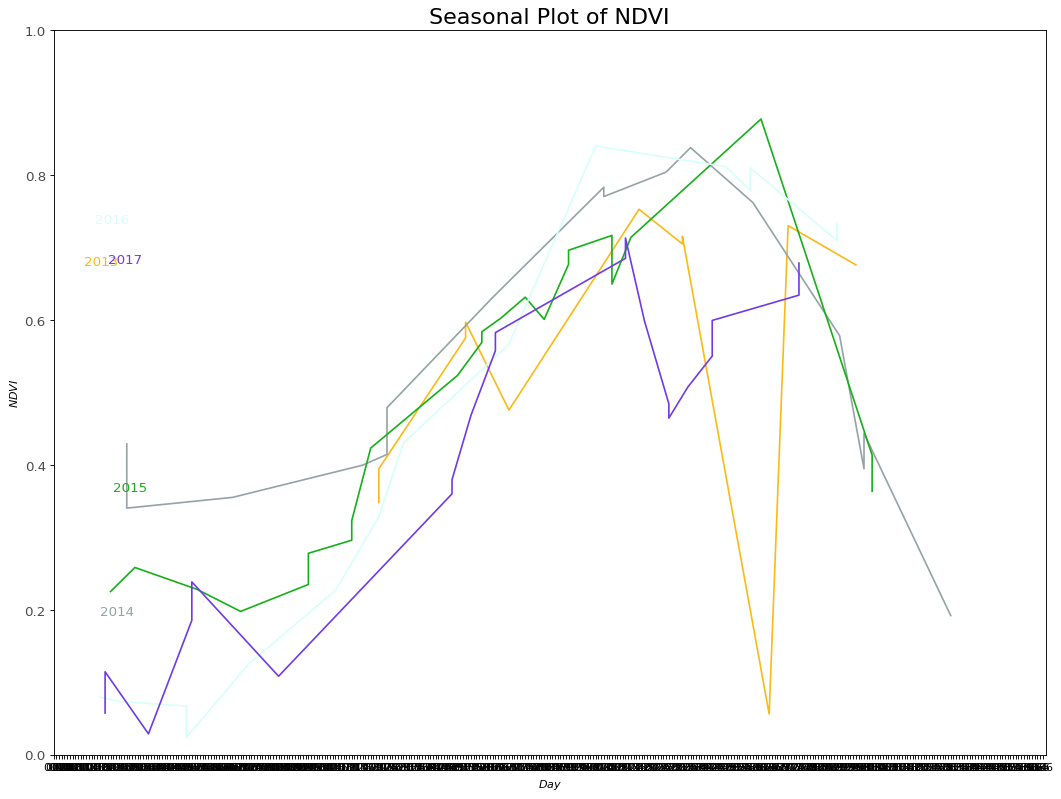

In [0]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Import Data
df5 = df_NDVI_all_days2
#df5.reset_index(inplace=True)

# Prepare data
df5['year'] = [d.year for d in df5.Date]
df5['day'] = [d.strftime('%j') for d in df5.Date]
years = df5['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('day', 'NDVI', data=df5.loc[df5.year==y, :], color=mycolors[i], label=y)
        plt.text(df5.loc[df5.year==y, :].shape[0]-.9, df5.loc[df5.year==y, 'NDVI'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(xlim=(0, 366), ylim=(0, 1), ylabel='$NDVI$', xlabel='$Day$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of NDVI", fontsize=20)
plt.show()